In [1]:
import requests as rq
import pandas as pd
import matplotlib.pyplot as mpl
import bs4
import os

from tqdm import tqdm_notebook

from datetime import time
%matplotlib inline

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Query Data

Grab schedule page:

In [3]:
base_url = "https://pydata.org"
r = rq.get(base_url + "/berlin2017/schedule/")
bs = bs4.BeautifulSoup(r.text, "html.parser")

Let's query every talk description:

In [4]:
data = {}
for ahref in tqdm_notebook(bs.find_all("a")):
    if 'schedule/presentation' in ahref.get("href"):
        url = ahref.get("href")
    else:
        continue
    data[url] = {}
    resp = bs4.BeautifulSoup(rq.get(base_url + url).text, "html.parser")
    title = resp.find("h2").text
    resp = resp.find_all(attrs={'class':"container"})[1]

    when, who = resp.find_all("h4")
    date_info = when.string.split("\n")[1:]
    day_info = date_info[0].strip()
    time_inf = date_info[1].strip()
    room_inf = date_info[3].strip()[3:]
    speaker = who.find("a").text
    level =  resp.find("dd").text
    abstract = resp.find(attrs={'class':'abstract'}).text
    description = resp.find(attrs={'class':'description'}).text
    data[url] = {
        'day_info': day_info, 
        'title': title,
        'time_inf': time_inf, 
        'room_inf': room_inf, 
        'speaker': speaker, 
        'level': level, 
        'abstract': abstract, 
        'description': description
    }

Okay, make a dataframe and add some helpful columns:

In [5]:
df = pd.DataFrame.from_dict(data, orient='index')
df.reset_index(drop=True, inplace=True)

# Show Profile Report of Pandas DF

In [6]:
import pandas_profiling as pp
pfr = pp.ProfileReport(df)

/Users/nico.albers/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [7]:
from IPython.display import display, HTML
display(HTML(
    pfr.html.replace("<h3", "<h4").replace("<h2", "<h3").replace("<h1", "<h2")
))

# Further Processing

In [8]:
# Tutorials on Friday
df.loc[df.day_info=='Friday', 'tutorial'] = True
df['tutorial'].fillna(False, inplace=True)

In [9]:
# time handling
df['time_from'], df['time_to'] = zip(*df.time_inf.str.split(u'\u2013'))
df.time_from = pd.to_datetime(df.time_from).dt.time
df.time_to = pd.to_datetime(df.time_to).dt.time
del df['time_inf']

In [10]:
df.head(3)

,day_info,speaker,room_inf,title,abstract,level,description,tutorial,time_from,time_to
0,Friday,Alexandru Agachi,A238,Introductory tutorial on data exploration and ...,I would be happy to conduct an introductory le...,Novice,This tutorial will focus on analyzing a datase...,True,13:45:00,15:15:00
1,Friday,Adrin Jalali,A130,The path between developing and serving machin...,Whenever you have a machine learning module in...,Experienced,"As a data scientist, one of the challenges aft...",True,15:30:00,17:00:00
2,Friday,David Higgins,A130,Introduction to Julia for Scientific Computing...,"Julia is a new and exciting language, sponsore...",Intermediate,"Developed at MIT, with a focus on fast numeric...",True,09:00:00,10:30:00


In [11]:
# Example: Let's query all non-novice talks on sunday, starting at 4 pm
tmp = df.query("(level!='Novice') & (day_info=='Sunday')")
tmp[tmp.time_from >= time(16)]

,day_info,speaker,room_inf,title,abstract,level,description,tutorial,time_from,time_to
7,Sunday,Hendrik Heuer,D105 Audimax,Data Science for Digital Humanities: Extractin...,The focus of this talk is extracting meaning f...,Intermediate,Analyzing millions of images and enormous text...,False,17:00:00,17:45:00
12,Sunday,Alexey Grigorev,A238,Large Scale Vandalism Detection in Knowledge B...,Knowledge bases are an important source of inf...,Intermediate,Wikidata is a Knowledge Base where anybody can...,False,17:00:00,17:45:00
14,Sunday,Jonathan Ronen,D105 Audimax,Social Networks and Protest Participation: Evi...,Pinning down the role of social ties in the de...,Intermediate,Data mining social networks for evidence of po...,False,17:45:00,18:30:00
24,Sunday,Daniele Rapati,A208,Engage the Hyper-Python - a rattle-through man...,A fast paced high-level overview of speed opti...,Intermediate,A fast paced high-level overview of speed opti...,False,17:45:00,18:30:00
26,Sunday,Vaibhav Singh,A238,Machine Learning to moderate ads in real world...,"In an online classified's business, one may en...",Intermediate,"In todays world of online business, it is diff...",False,17:45:00,18:30:00
30,Sunday,Oliver Eberle,A208,Where are we looking? Prediciting human gaze u...,Visual saliency models aim at describing human...,Intermediate,Which features in an image draw our focus to a...,False,17:00:00,17:45:00
39,Sunday,Lev Konstantinovskiy,A208,Find the text similiarity you need with the ne...,There are many ways to find similar words/docs...,Intermediate,"What is the closest word to ""king""? Is it ""Can...",False,16:00:00,16:45:00
45,Sunday,Roelof Pieters,D105 Audimax,AI assisted creativity,A new wave of creative applications of AI has ...,Intermediate,A new wave of creative applications of AI has ...,False,16:00:00,16:45:00


# visualize some relations

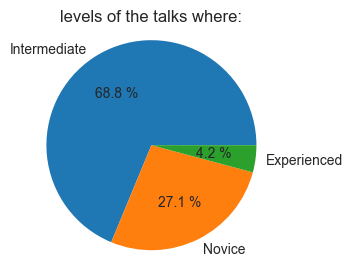

In [12]:
ax = df.level.value_counts().plot.pie(figsize=(3,3), autopct="%1.1f %%")
ax.axis("equal")
ax.set_ylabel("")
ax.set_title("levels of the talks where:")
plt.show()

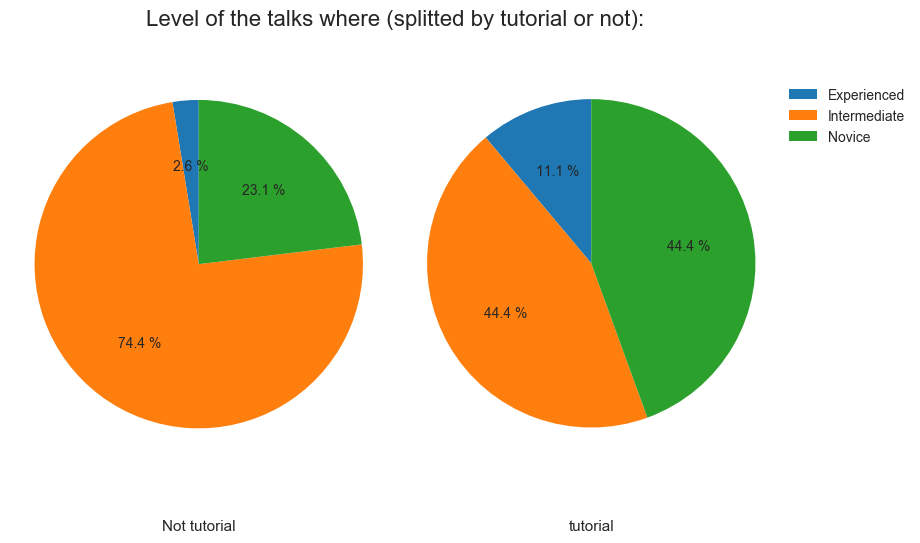

In [13]:
ax = df.groupby("tutorial")['level'].value_counts().unstack(level=0).plot.pie(
    subplots=True, legend=False, autopct="%1.1f %%", startangle=90, labels=["","",""])
for axx in ax:
    axx.axis("equal")
    axx.set_ylabel("")
ax[0].set_xlabel("Not tutorial")   
ax[1].set_xlabel("tutorial")
plt.gcf().suptitle("Level of the talks where (splitted by tutorial or not):", fontsize=16)
plt.tight_layout()
axx.legend(
    df.groupby("tutorial")['level'].value_counts().unstack(level=0).index.tolist(),
    loc='center left', bbox_to_anchor=(1, .8))
plt.show()

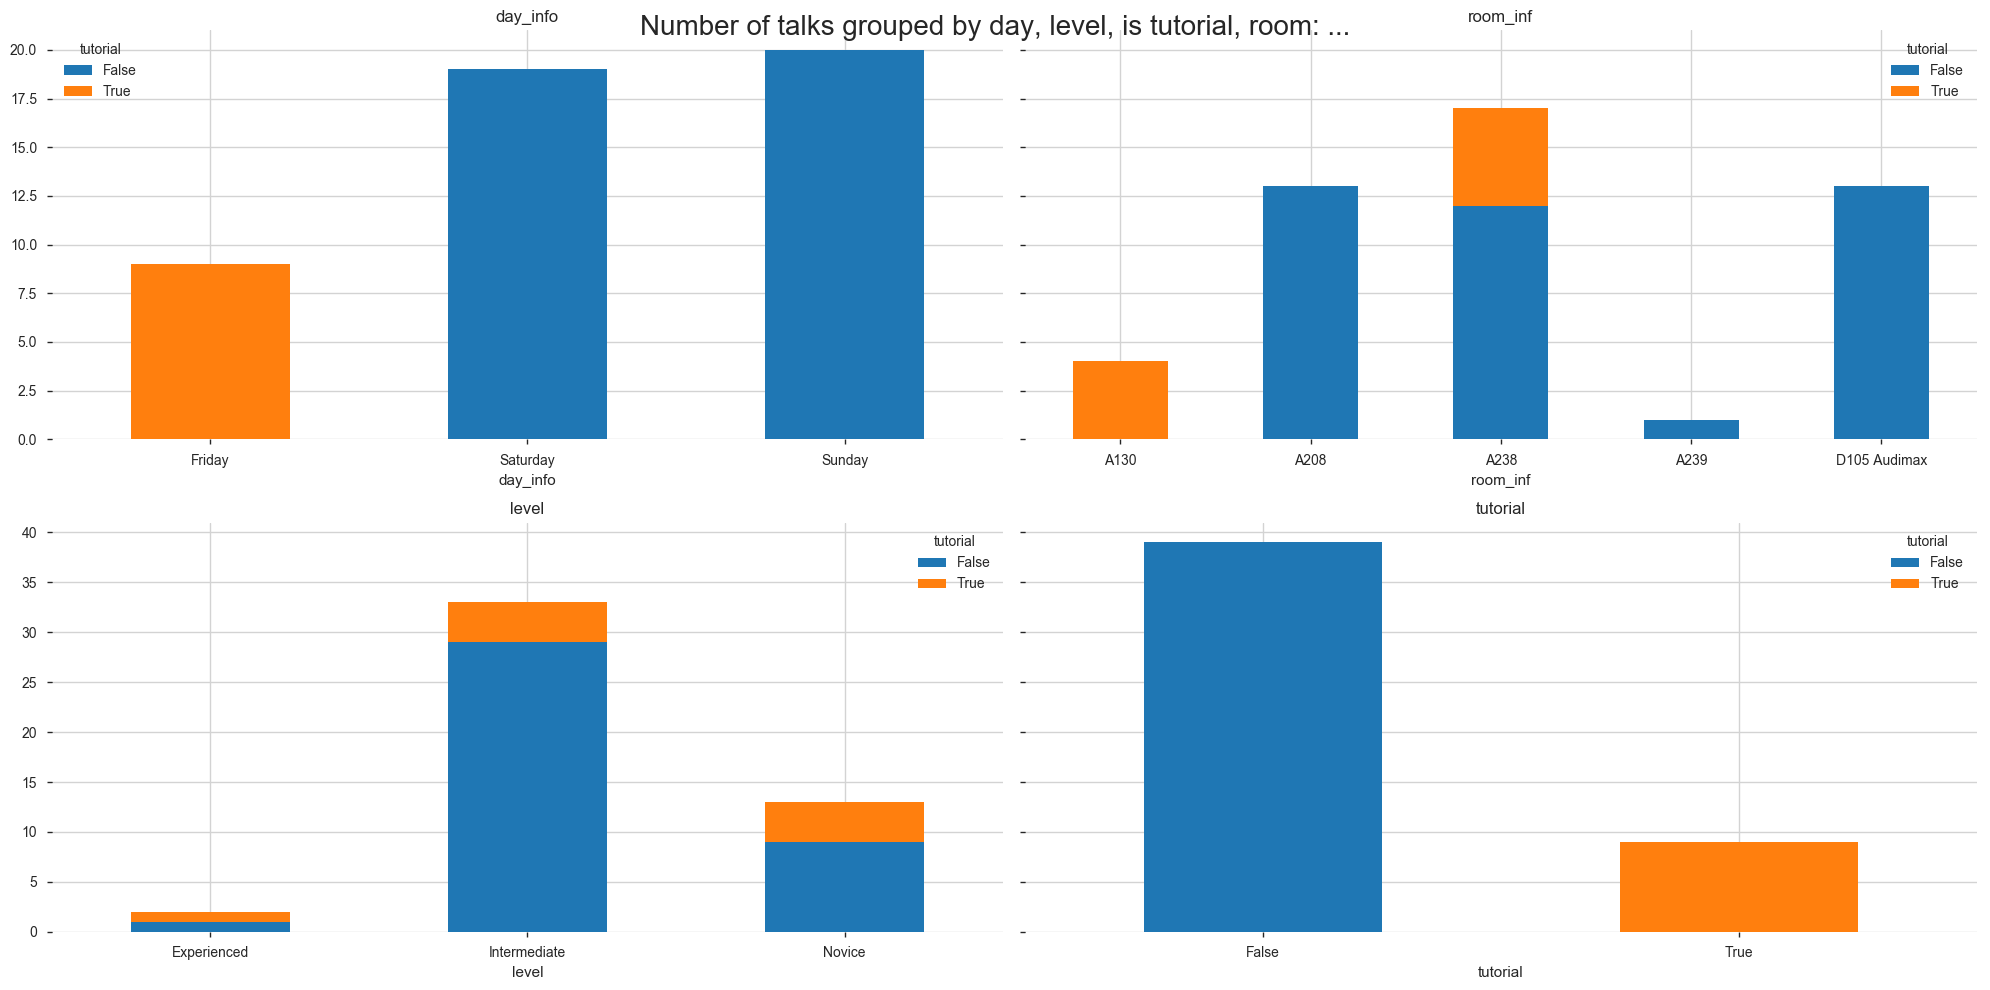

In [14]:
categorical_cols = [col for col in df.columns if len(df[col].unique())<=len(df[col]) / 5]
f, ax = plt.subplots(2,2, figsize=(20,10), sharey="row")
for i, axx in enumerate(ax.flatten()):
    col = categorical_cols[i]
    df.groupby("tutorial")[col].value_counts().unstack(level=0).plot.bar(ax=axx, rot=0, stacked=True)
    axx.set_title(col)
    axx.set_facecolor("white")
    axx.grid(True, color="lightgrey")
f.suptitle("Number of talks grouped by day, level, is tutorial, room: ...", fontsize=20)
f.tight_layout()


<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />

# Test Meadow
The following is just <b>WIP crap</b> - do not read this.

In [ ]:
df.title = df.title.str.replace(".", "").replace(":", "").replace(",", "")

In [ ]:
from itertools import chain

In [ ]:
foo = pd.DataFrame(
    pd.Series(list(chain(*df.title.str.split().apply(lambda x: np.unique(x)).tolist()))).value_counts(normalize=True)
).reset_index().rename(columns={0:'share', 'index': 'word'}).query("share >= 0.001")

In [ ]:
foo.head()

In [ ]:
foo['len'] = foo.word.str.len()

In [ ]:
from gensim import corpora, models, similarities

In [ ]:
documents = df.query("tutorial != True").title.tolist()

In [ ]:
stoplist = set('''
    for a of the and to in i be on with here we will an each its type as our their then apply them very would this
    make large talk, basic search is are there more than pages it can or that they how by have what from talk use you
    these using which but some not your do used at if like such has about - my one most those should between may good • why
    give way time been need many so does case when also all into lot build features new who often discuss building
    best text * was out
    '''.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
        for document in documents]

In [ ]:
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

In [ ]:
pd.DataFrame(dict(nr=dict(frequency))).sort_values('nr', ascending=False).query("nr>1")

In [ ]:
keywords = pd.DataFrame(dict(nr=dict(frequency))).sort_values('nr', ascending=False).query("nr>1").index.tolist()

In [ ]:
for keyword in keywords[::-1]:
    df.loc[df.title.str.lower().str.contains(keyword), 'color'] = keyword
df.color.fillna("UNKNOWN", inplace=True)

In [ ]:
df.head()

In [ ]:
pd.set_option("max.colwidth", 400)

In [ ]:
df['approach'] = np.where(df.tutorial, "tutorial", np.nan)
df.loc[df.title.str.lower().str.contains('ai'), 'approach'] = 'artificial intelligence'
df.loc[df.title.str.lower().str.contains('artificial intelligence'), 'approach'] = 'artificial intelligence'
df.loc[df.title.str.lower().str.contains('pandas'), 'approach'] = 'pandas'
df.loc[df.title.str.lower().str.contains('jupyter'), 'approach'] = 'jupyter'
df.loc[df.title.str.lower().str.contains('data scien'), 'approach'] = 'data science'
df.loc[df.title.str.lower().str.contains('machine learn'), 'approach'] = 'machine learning'
df.loc[df.title.str.lower().str.contains('deep'), 'approach'] = 'deep learning'

In [ ]:
# attention: may change when querying again
df.loc[11, 'approach'] = 'R'
df.loc[13, 'approach'] = 'Julia'

In [ ]:
df.loc[df.title.apply(lambda x: any([y in x.lower() for y in ['question', 'text', 'natural language', 'nlp', 'doc2vec']])), 'type'] = 'text / NLP'
df.loc[df.title.apply(lambda x: any([y in x.lower() for y in ['creativ', 'image', 'signal process', ]])), 'type'] = 'image process'
df['type'] = np.where(df.tutorial, "tutorial", df.type)

In [ ]:
print '{'
for title in df.title:
    if df.loc[df.title==title, 'tutorial'].values[0]:
        continue
    print "\t'" + title + "': '',"
print '}'

In [ ]:
pd.DataFrame({'bla':rename_dict})

In [ ]:
df['type'] = df.title.map(rename_dict)

In [ ]:
df.groupby(["type", "level", "approach"]).color.count().reset_index().head(1)

In [ ]:
gb = df.groupby(["type", "approach"]).color.count()#.reset_index()

In [ ]:
for col in ['type', 'level', 'approach']:
    gb[col] = gb[col].astype("category", )

In [ ]:
cats = gb.level.unique()

In [ ]:
gb.level.astype()

In [ ]:
gb.unstack(level=1).plot.barh()

- x axis: mean level
- y axis:
- size: number of times
- color: type?!

In [ ]:
rename_dict = {
    'Introduction to Search': 'search',
    'Data Science for Digital Humanities: Extracting meaning from Images and Text': 'text / NLP / *2vec',
    'TNaaS - Tech Names as a Service': 'creativity',
    'Developments in Test-Driven Data Analysis': 'testing',
    'Analysing user comments on news articels with Doc2Vec and Machine Learning classification': 'text / NLP / *2vec',
    'Patsy: The Lingua Franca to and from R': 'R',
    'Large Scale Vandalism Detection in Knowledge Bases': 'network data',
    'Fast Multidimensional Signal Processing using Julia with Shearlabjl': 'images',
    'Social Networks and Protest Participation: Evidence from 130 Million Twitter Users': 'ethics & social',
    'Patterns for Collaboration between Data Scientists And Software Engineers': 'tools / frameworks',
    'Blockchains for Artificial Intelligence': 'blockchain',
    'Data Analytics and the new European Privacy Legislation': 'laws',
    'Building smart IoT applications with Python and Spark': 'iot',
    '“Which car fits my life?”  - mobilede’s approach to recommendations': 'recommendation',
    'Towards Pythonic Innovation in Recommender Systems': 'recommendation',
    'Gold standard data: lessons from the trenches': 'tools / frameworks',
    'Biases are bugs: algorithm fairness and machine learning ethics': 'ethics & social',
    'On Bandits, Bayes, and swipes: gamification of search': 'active learning',
    'Engage the Hyper-Python - a rattle-through many of the ways you can make a Python program faster': 'tools / frameworks',
    'Fairness and transparency in machine learning: Tools and techniques': 'ethics & social',
    "Machine Learning to moderate ads in real world classified's business": '',
    'Size Matters! A/B Testing When Not Knowing Your Number of Trials': '',
    'Is That a Duplicate Quora Question?': 'text / NLP / *2vec',
    'Semi-Supervised Bootstrapping of Relationship Extractors with Distributional Semantics': '',
    'Where are we looking? Prediciting human gaze using deep networks': '',
    'Spying on my Network for a Day: Data Analysis for Networks': 'network data',
    'Deep Learning for detection on a phone: how to stay sane and build a pipeline you can trust': '',
    'A word is worth a thousand pictures: Convolutional methods for text': 'text / NLP / *2vec',
    'Polynomial Chaos: A technique for modeling uncertainty': '',
    'Kickstarting projects with Cookiecutter': 'tools / frameworks',
    'What does it all mean? - Compositional distributional semantics for modelling natural language': 'text / NLP / *2vec',
    'When the grassroots grow stronger - 2017 through the eyes of German open data activists': 'ethics & social',
    'Finding Lane Lines for Self Driving Cars': 'images',
    'Find the text similiarity you need with the next generation of word embeddings in Gensim': 'text / NLP / *2vec',
    'Evaluating Topic Models': 'text / NLP / *2vec',
    'Best Practices for Debugging': 'tools / frameworks',
    'Data Science & Data Visualization in Python How to harness power of Python for social good?': 'ethics & social',
    'Conversational AI: Building clever chatbots': '',
    'AI assisted creativity': 'creativity',
}

In [ ]:
df[['title', 'type', 'approach']]

In [ ]:
df.groupby(["color", "day_info"])['level'].count().unstack(level=0).plot.bar(rot=0, cmap='inferno')